# Task: Inventory Management
## What's The Problem?

![Alt](Task-InventoryManagement.png "Task: Inventory Management")

## A delicate balancing act:


* Too Much Inventory   --->     **Wasted Floor Space!!**
* Not Enough Inventory --->     **Lost Potential Revenue!!**


## *We Need To Match Our Inventory To Demand!*

# Exploring The Dataset

In [65]:
import pandas as pd
import openpyxl
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

In [2]:
df = pd.read_excel("Data Science Assignment.xlsx")
df

,week,product,orders,brand,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,Big Cable Brand,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0
...,...,...,...,...,...,...,...,...
255,11/1/2020,E,5.0,Little Cable Brand,853.0,21.0,119.99,62
256,11/8/2020,E,4.0,Little Cable Brand,528.0,7.0,139.99,58
257,11/15/2020,E,10.0,Little Cable Brand,846.0,31.0,79.99,48
258,11/22/2020,E,12.0,Little Cable Brand,770.0,24.0,59.99,75


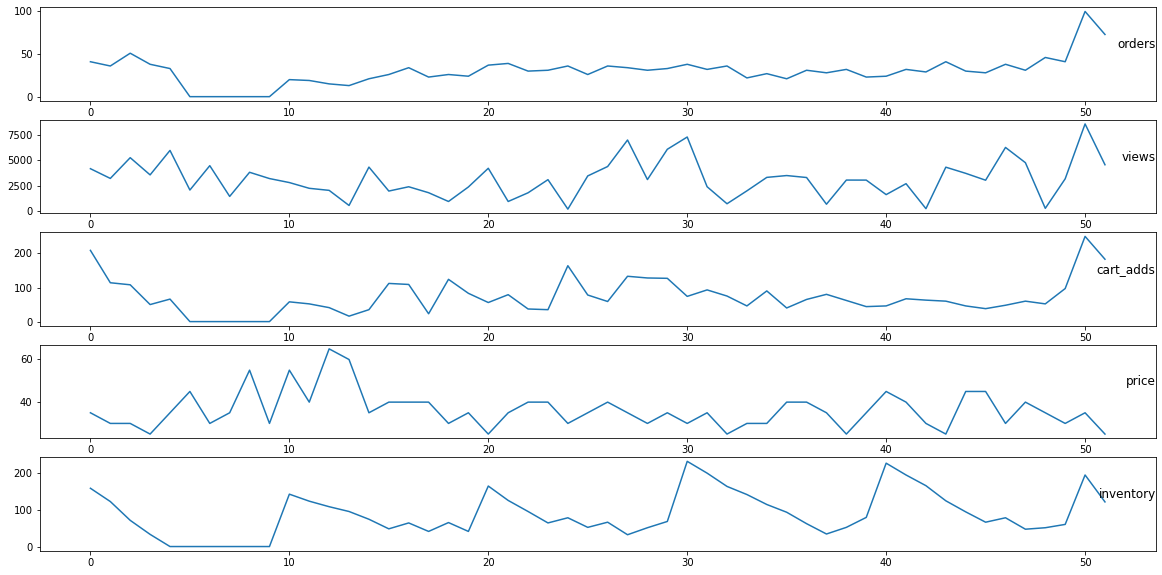

In [96]:
def plot_signals(product):
    signals = [2, 4, 5, 6, 7]
    values = product.values
    plt.figure(figsize=(20,10))
    i=1
    for sig in signals:
        plt.subplot(len(signals), 1, i)
        plt.plot(values[:, sig])
        plt.title(product.columns[sig], y=0.5, loc='right')
        i += 1
    plt.show()

product_B = df.loc[df["product"] == "A"]
plot_signals(product_B)

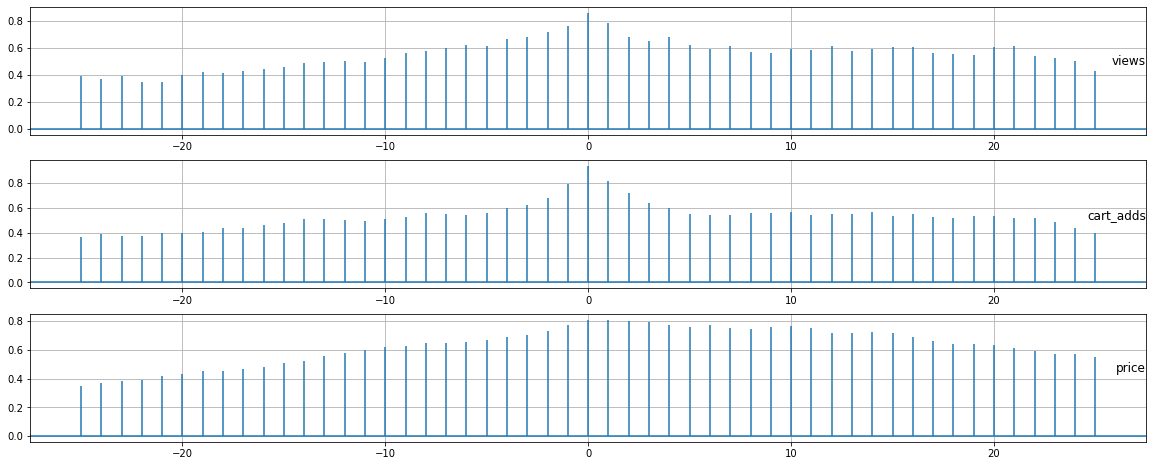

In [97]:
def correlate_signals(product):
    product = product.ffill()
    corr_signals = [4, 5, 6]
    values = product.values
    i=1
    plt.figure(figsize=(20,8))
    for sig in corr_signals:
        plt.subplot(len(corr_signals), 1, i)
        plt.xcorr(values[:, 2], values[:, sig], maxlags=25, normed=True)
        plt.title(product.columns[sig], y=0.5, loc='right')
        i += 1
        plt.grid(True)
    plt.show()

product_B = df.loc[df["product"] == "A"]
correlate_signals(product_B)
#product_B

# Forecasting

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


array([4181., 3228., 5259., 3574., 5970., 2091., 4476., 1466., 3829.,
       3215., 2823., 2260., 2059.,  581., 4337., 1991., 2412., 1829.,
        970., 2391., 4221.,  970., 1822., 3107.,  221., 3473., 4394.,
       6989., 3115., 6082., 7282., 2414.,  748., 2011., 3330., 3509.,
       3317.,  703., 3067., 3064., 1643., 2761., 2747., 2733., 2718.,
       2704., 2689., 2675., 2661., 2646., 2632., 2617.])

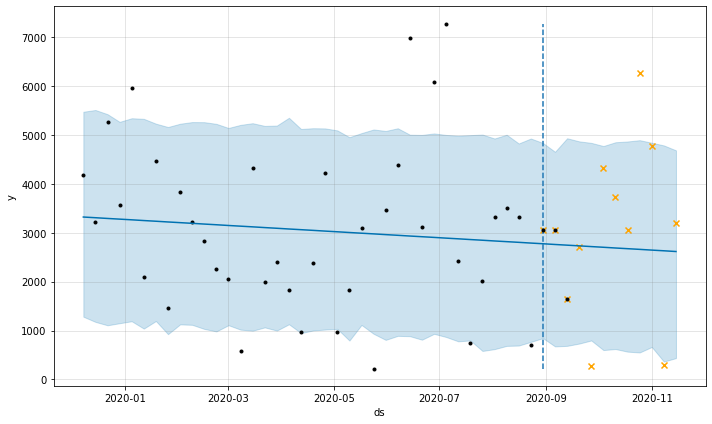

In [74]:
def forecast_views(product, plot=False):
    
    product = product.ffill()
    
    product = product[:-2]

    product = product[["week", 'views']].rename(columns={"week":"ds", "views":"y"})
    test = product[-10:]
    train = product[:-9]


    model = Prophet(weekly_seasonality=True)
    model.add_country_holidays(country_name='US')

    model.fit(train)
    future = product
    forecast = model.predict(future)
    product = product['y'].reset_index()
    forecast["ground_truth"] = product['y']
    forecast["yhat"] = forecast["yhat"].apply(lambda x: 0 if x<0 else x)
    forecast["yhat"] = forecast["yhat"].apply(lambda x: math.ceil(x))
    forecast["yhat_lower"] = forecast["yhat_lower"].apply(lambda x: 0 if x<0 else x)
    forecast["yhat_upper"] = forecast["yhat_upper"].apply(lambda x: 0 if x<0 else x)
    
    if plot:
        fig1 = model.plot(forecast)
        plt.scatter(forecast.values[-12:,0],forecast.values[-12:,-1],c='orange', marker='x')
        plt.vlines(forecast.values[-12,0],min(min(forecast['yhat'].values), min(forecast['ground_truth'].values)),max(max(forecast['yhat'].values), max(forecast['ground_truth'].values)),linestyles='dashed')

    
    forecast_data = np.concatenate((train['y'].to_numpy(), forecast["yhat"].to_numpy()[-11:]))
    
    return forecast_data
    
product = df.loc[df["product"] == "A"]
forecast_views(product, plot=True)

In [90]:
def forecast_orders(product):
    start = time.time()
    
    product = product.ffill()
    product = product[:-2]
    
    views = forecast_views(product)
    product = product.drop(['views'], axis=1)
    product['views'] = views

    product = product[["week", 'orders', 'price', 'views']].rename(columns={"week":"ds", "orders":"y"})
    test = product[-10:]
    train = product[:-9]


    model = Prophet(weekly_seasonality=True)
    model.add_country_holidays(country_name='US')
    model.add_regressor('price', prior_scale=0.5, mode='multiplicative')
    model.add_regressor('views', prior_scale=0.5, mode='multiplicative')
    model.fit(train)
    future = product
    forecast = model.predict(future)
    product = product['y'].reset_index()
    forecast["ground_truth"] = product['y']
    forecast["yhat"] = forecast["yhat"].apply(lambda x: 0 if x<0 else x)
    forecast["yhat"] = forecast["yhat"].apply(lambda x: math.ceil(x))
    forecast["yhat_lower"] = forecast["yhat_lower"].apply(lambda x: 0 if x<0 else x)
    forecast["yhat_upper"] = forecast["yhat_upper"].apply(lambda x: 0 if x<0 else x)

    fig1 = model.plot(forecast)
    plt.scatter(forecast.values[-10:,0],forecast.values[-10:,-1],c='orange', marker='x')
    plt.vlines(forecast.values[-10,0],min(min(forecast['yhat'].values), min(forecast['ground_truth'].values)),max(max(forecast['yhat'].values), max(forecast['ground_truth'].values)),linestyles='dashed')
    
    
    mae = mean_absolute_error(forecast["ground_truth"].to_numpy(), forecast["yhat"].to_numpy())
    mse = mean_squared_error(forecast["ground_truth"].to_numpy(), forecast["yhat"].to_numpy())
    rmse = sqrt(mse)
    end = time.time()
    
    forecasted_inv = sum(forecast['yhat'].values[-10:])
    real_inv = sum(forecast['ground_truth'].values[-10:])
    
    print(":::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::")
    print()
    print(f"Forecasted Inventory Requirement: {forecasted_inv}")
    print(f"Real Inventory Requirement: {real_inv}")
    print()
    print(f"{round(abs(100*(forecasted_inv-real_inv)/real_inv),1)}% difference between forecast and reality")
    print()
    print(":::MODEL ERROR:::")
    print()
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Square Error: {mse}")
    print(f"Root Mean Square Error: {rmse}")
    print(f"RUNTIME: {round(end-start,3)} secs")

# Results:

## Product A

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


:::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::

Forecasted Inventory Requirement: 305
Real Inventory Requirement: 340.0

10.3% difference between forecast and reality

:::MODEL ERROR:::

Mean Absolute Error: 7.1
Mean Square Error: 99.26
Root Mean Square Error: 9.962931295557548
RUNTIME: 4.382 secs


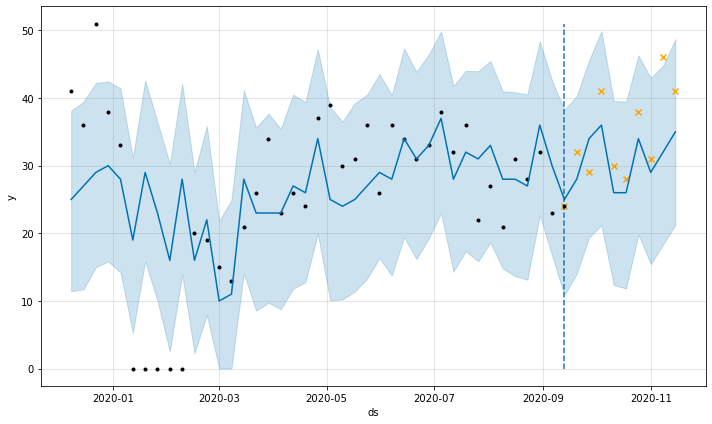

In [91]:
product = df.loc[df["product"] == "A"]
forecast_orders(product)

## Product B

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


:::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::

Forecasted Inventory Requirement: 117
Real Inventory Requirement: 61.0

91.8% difference between forecast and reality

:::MODEL ERROR:::

Mean Absolute Error: 2.72
Mean Square Error: 12.04
Root Mean Square Error: 3.4698703145794942
RUNTIME: 5.19 secs


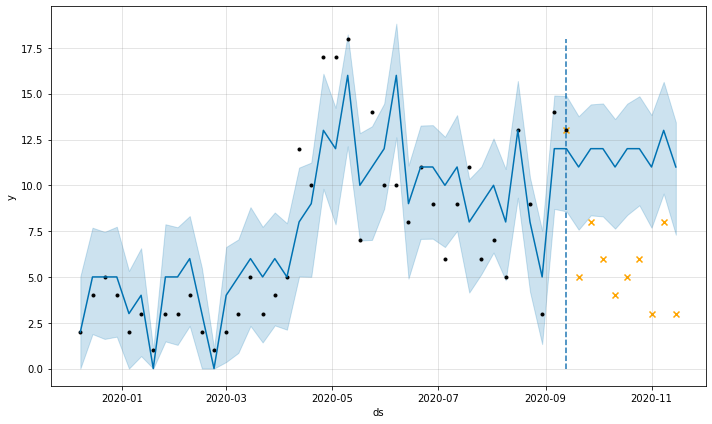

In [92]:
product = df.loc[df["product"] == "B"]
forecast_orders(product)

## Product C

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


:::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::

Forecasted Inventory Requirement: 243
Real Inventory Requirement: 222.0

9.5% difference between forecast and reality

:::MODEL ERROR:::

Mean Absolute Error: 4.14
Mean Square Error: 26.7
Root Mean Square Error: 5.167204273105526
RUNTIME: 4.504 secs


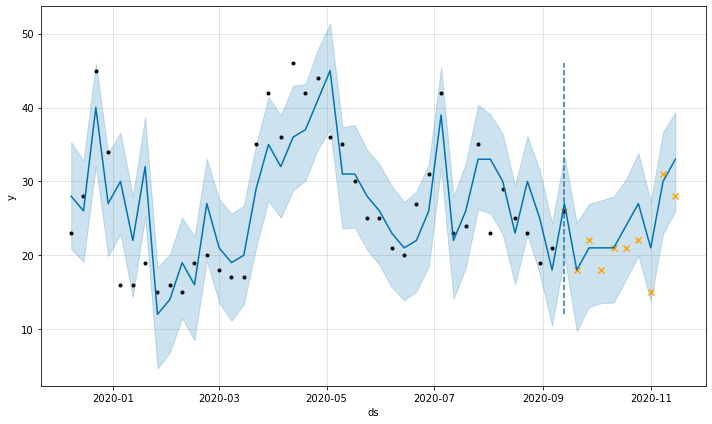

In [93]:
product = df.loc[df["product"] == "C"]
forecast_orders(product)

## Product D

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


:::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::

Forecasted Inventory Requirement: 507
Real Inventory Requirement: 273.0

85.7% difference between forecast and reality

:::MODEL ERROR:::

Mean Absolute Error: 11.36
Mean Square Error: 230.92
Root Mean Square Error: 15.1960521188893
RUNTIME: 4.661 secs


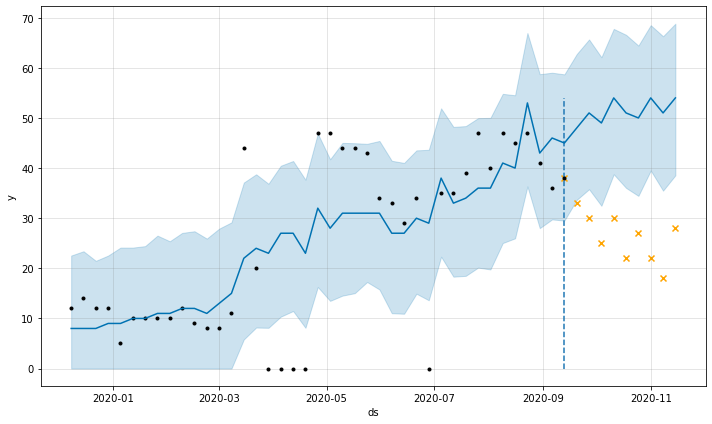

In [94]:
product = df.loc[df["product"] == "D"]
forecast_orders(product)

## Product E

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


:::FORECASTED INVENTORY REQUIREMENT FOR NEXT 10 WEEKS:::

Forecasted Inventory Requirement: 69
Real Inventory Requirement: 65.0

6.2% difference between forecast and reality

:::MODEL ERROR:::

Mean Absolute Error: 1.34
Mean Square Error: 3.02
Root Mean Square Error: 1.7378147196982767
RUNTIME: 6.319 secs


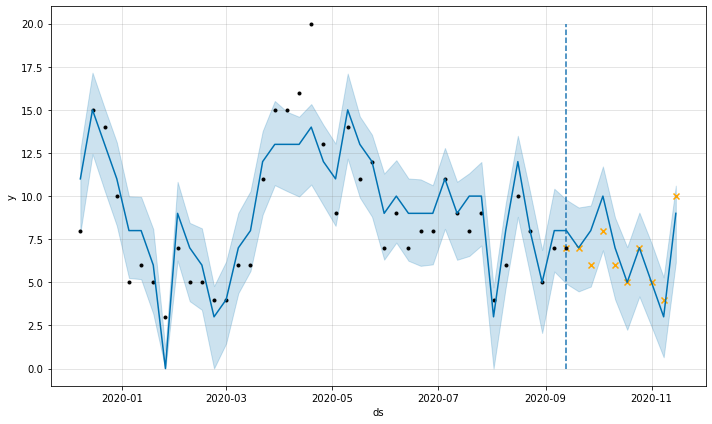

In [95]:
product = df.loc[df["product"] == "E"]
forecast_orders(product)

# Takeaways:

### 1.  Strong Correlation Between User Behaviour And Orders Placed
### 2.  Price Drops Tend To Increase Orders
### 3.  More Data Is Better !!